Dataset split (train/test) ready.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s]


Epoch [1/100] - Train Loss: 0.8456 | Train Acc: 92.89%
  ↳ New best loss. Saved: resnet50_malimg_best.pth
Epoch [2/100] - Train Loss: 0.2635 | Train Acc: 98.95%
  ↳ New best loss. Saved: resnet50_malimg_best.pth
Epoch [3/100] - Train Loss: 0.1971 | Train Acc: 99.34%
  ↳ New best loss. Saved: resnet50_malimg_best.pth
Epoch [4/100] - Train Loss: 0.1560 | Train Acc: 99.44%
  ↳ New best loss. Saved: resnet50_malimg_best.pth
Epoch [5/100] - Train Loss: 0.1072 | Train Acc: 99.65%
  ↳ New best loss. Saved: resnet50_malimg_best.pth
Epoch [6/100] - Train Loss: 0.1506 | Train Acc: 98.95%
  ↳ No improvement (1/5)
Epoch [7/100] - Train Loss: 0.0821 | Train Acc: 99.76%
  ↳ New best loss. Saved: resnet50_malimg_best.pth
Epoch [8/100] - Train Loss: 0.1782 | Train Acc: 99.37%
  ↳ No improvement (1/5)
Epoch [9/100] - Train Loss: 0.1179 | Train Acc: 99.66%
  ↳ No improvement (2/5)
Epoch [10/100] - Train Loss: 0.0775 | Train Acc: 99.73%
  ↳ New best loss. Saved: resnet50_malimg_best.pth
Epoch [11/100] - 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


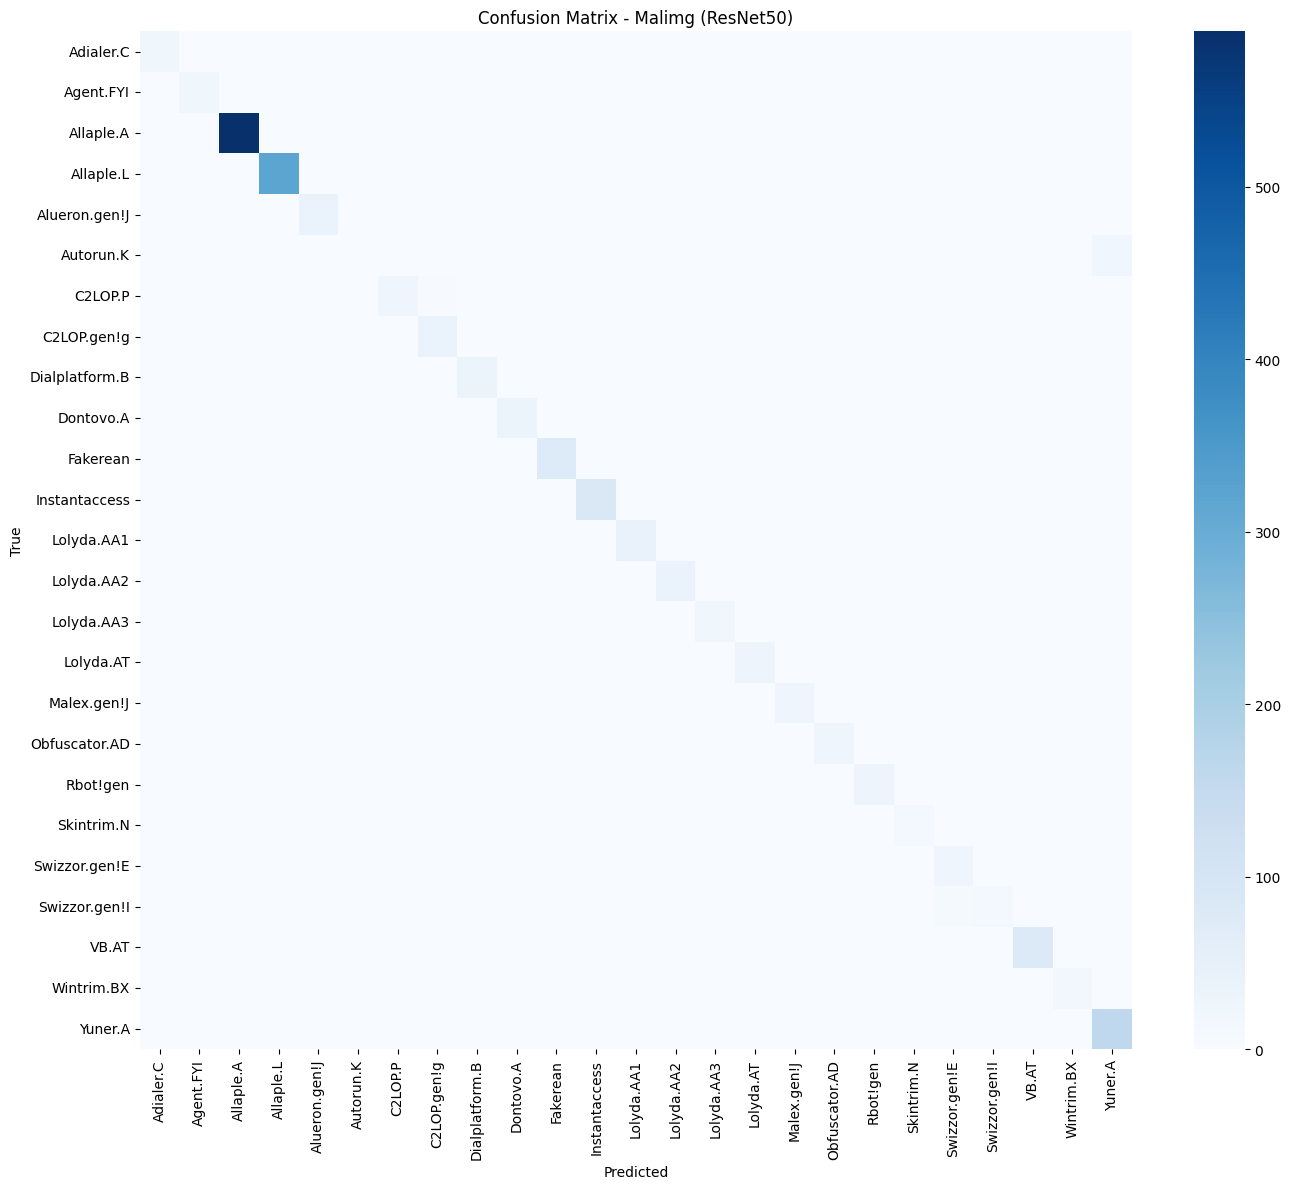

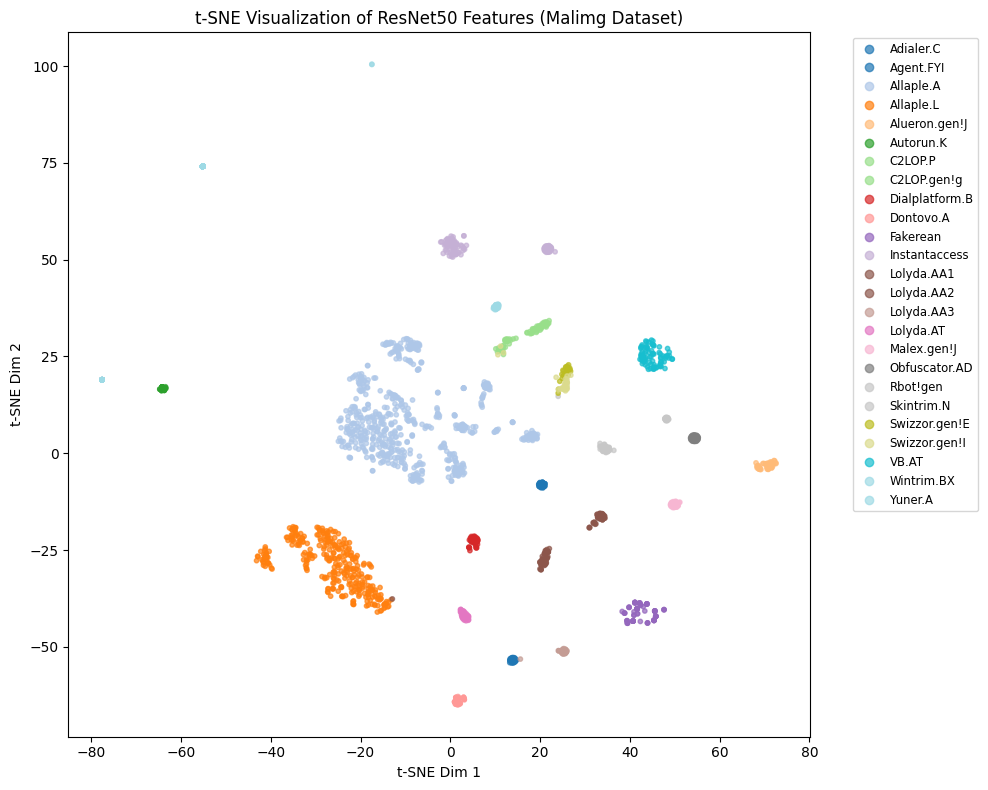

In [1]:
import os, shutil, random, time, math
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# ============================
# 1) Paths & Hyperparameters
# ============================
root_dir = "/kaggle/input/malimg"
working_dir = "/kaggle/working/Malimg_split_train_test"
batch_size = 128
num_epochs = 100                 # upper bound; early stopping will cut earlier
learning_rate = 1e-4
patience = 5                    # <-- early stopping patience (epochs)
min_delta = 1e-4                # <-- required improvement in loss to reset patience
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# 2) Split Dataset (Train/Test only)
# ============================
def split_dataset_train_test(train_ratio=0.2, test_ratio=0.8):
    assert abs(train_ratio + test_ratio - 1.0) < 1e-6
    os.makedirs(working_dir, exist_ok=True)
    for s in ["train","test"]:
        os.makedirs(os.path.join(working_dir, s), exist_ok=True)

    # if already split, skip heavy copying
    if any(len(os.listdir(os.path.join(working_dir, s))) == 0 for s in ["train","test"]):
        for cls in sorted(os.listdir(root_dir)):
            cls_dir = os.path.join(root_dir, cls)
            if not os.path.isdir(cls_dir): continue
            files = [f for f in os.listdir(cls_dir) if os.path.isfile(os.path.join(cls_dir, f))]
            random.shuffle(files)
            n_total = len(files); n_train = int(0.8*n_total)
            for split, fs in {"train":files[:n_train], "test":files[n_train:]}.items():
                out_dir = os.path.join(working_dir, split, cls)
                os.makedirs(out_dir, exist_ok=True)
                for f in fs:
                    src = os.path.join(cls_dir, f)
                    dst = os.path.join(out_dir, f)
                    if not os.path.exists(dst):
                        shutil.copy(src, dst)

split_dataset_train_test()
print("Dataset split (train/test) ready.")

# ============================
# 3) Transforms (Grayscale -> RGB)
# ============================
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ============================
# 4) Dataset & DataLoader
# ============================
train_dataset = datasets.ImageFolder(f"{working_dir}/train", transform=train_transform)
test_dataset  = datasets.ImageFolder(f"{working_dir}/test",  transform=test_transform)

class_names = train_dataset.classes
num_classes = len(class_names)

labels = [label for _, label in train_dataset.samples]
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)

sample_weights = [1.0 / class_weights[label].item() for _, label in train_dataset.samples]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# ============================
# 5) Model, Loss, Optimizer
# ============================
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# ============================
# 6) Training with Early Stopping (train acc + time)
# ============================
start_time = time.time()
best_loss = math.inf
epochs_no_improve = 0
best_path = "resnet50_malimg_best.pth"

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0

    for imgs, targets in train_loader:
        imgs, targets = imgs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        running_correct += preds.eq(targets).sum().item()
        running_total += targets.size(0)

    avg_loss = running_loss / max(1, len(train_loader))
    train_acc = 100.0 * running_correct / running_total
    print(f"Epoch [{epoch}/{num_epochs}] - Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}%")

    # ---- Early Stopping check on training loss (no val set) ----
    if best_loss - avg_loss > min_delta:
        best_loss = avg_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_path)
        print(f"  ↳ New best loss. Saved: {best_path}")
    else:
        epochs_no_improve += 1
        print(f"  ↳ No improvement ({epochs_no_improve}/{patience})")
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

train_time_sec = time.time() - start_time
print(f"Total Training Time: {train_time_sec:.2f} seconds ({train_time_sec/60:.2f} minutes)")

# Load best model before evaluation
model.load_state_dict(torch.load(best_path, map_location=device))

# ============================
# 7) Test Evaluation (Acc, Macro-F1, Report, Avg Inference Time)
# ============================
model.eval()
all_labels, all_preds = [], []
inference_images, inference_time = 0, 0.0

with torch.no_grad():
    for imgs, labels_batch in test_loader:
        imgs = imgs.to(device); labels_batch = labels_batch.to(device)
        t0 = time.time()
        outputs = model(imgs)
        inference_time += (time.time() - t0)
        _, preds = outputs.max(1)
        all_labels.extend(labels_batch.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())
        inference_images += labels_batch.size(0)

test_acc = accuracy_score(all_labels, all_preds) * 100.0
macro_f1 = f1_score(all_labels, all_preds, average="macro")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Macro F1: {macro_f1:.4f}")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

avg_infer_time_per_image_ms = (inference_time / max(1, inference_images)) * 1000.0
print(f"Average Inference Time per Image: {avg_infer_time_per_image_ms:.2f} ms")

# ============================
# 8) Confusion Matrix
# ============================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Malimg (ResNet50)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("confusion_matrix_resnet50.png", dpi=200)
plt.show()

# ============================
# 9) t-SNE Visualization (optional)
# ============================
features, labels_list = [], []
with torch.no_grad():
    for imgs, labels_batch in test_loader:
        imgs = imgs.to(device)
        feats = model.avgpool(
            model.layer4(
                model.layer3(
                    model.layer2(
                        model.layer1(
                            model.maxpool(
                                model.relu(model.bn1(model.conv1(imgs)))
                            )
                        )
                    )
                )
            )
        )
        feats = torch.flatten(feats, 1)
        features.append(feats.cpu().numpy())
        labels_list.extend(labels_batch.numpy())

features = np.concatenate(features, axis=0)
labels_list = np.array(labels_list)

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42, n_iter=1000)
features_tsne = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels_list, cmap="tab20", s=10, alpha=0.7)
handles, _ = scatter.legend_elements(num=len(class_names))
plt.legend(handles, class_names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="small")
plt.title("t-SNE Visualization of ResNet50 Features (Malimg Dataset)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.tight_layout()
plt.savefig("tsne_resnet50.png", dpi=200)
plt.show()
